In [1]:
# Librerías necesarias
#!pip install xgboost
#!pip install shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from scipy import stats

In [2]:

import pandas as pd
from sklearn.model_selection import train_test_split

# Leemos los datos desde el archivo CSV
filename = 'RS_13_15_final_dataset_UK.csv'  

# Definimos los nombres de las columnas según las cabeceras 
nombres = [
    'NS_AS1_avg', 'NS_AS1_max', 'NS_AS1_min', 
    'NS_AS2_avg', 'NS_AS2_max', 'NS_AS2_min',
    'NS_AS3_avg', 'NS_AS3_max', 'NS_AS3_min', 
    'NS_F1_avg', 'NS_F1_max', 'NS_F1_min', 
    'NS_F2_avg', 'NS_F2_max', 'NS_F2_min',
    'NS_F3_avg', 'NS_F3_max', 'NS_F3_min',
    'NS_E_avg', 'NS_E_max', 'NS_E_min', 
    'EW_AS1_avg', 'EW_AS1_max', 'EW_AS1_min', 
    'EW_AS2_avg', 'EW_AS2_max', 'EW_AS2_min',
    'EW_AS3_avg', 'EW_AS3_max', 'EW_AS3_min', 
    'EW_F1_avg', 'EW_F1_max', 'EW_F1_min', 
    'EW_F2_avg', 'EW_F2_max', 'EW_F2_min',
    'EW_F3_avg', 'EW_F3_max', 'EW_F3_min',
    'EW_E_avg', 'EW_E_max', 'EW_E_min', 
    'K_avg'  # Etiqueta/target
]

# Cargamos el archivo CSV en un DataFrame
DATA = pd.read_csv(filename, names=nombres, header=0)
pd.set_option('display.max_columns', None)

# Mostramos el tamaño del dataset y un resumen rápido
print(f"Datos cargados correctamente. Tamaño: {DATA.shape}")
print(DATA.head())  # Imprime las primeras 5 filas para verificar los datos

# Separación de las características (X) y la etiqueta objetivo (y)
X = DATA.drop('K_avg', axis=1)  # Las características son todas las columnas excepto la etiqueta (K_avg)
y = DATA['K_avg']  # La etiqueta objetivo es la última columna K_avg

# Dividimos los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostramos el tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")



Datos cargados correctamente. Tamaño: (365, 43)
   NS_AS1_avg  NS_AS1_max  NS_AS1_min  NS_AS2_avg  NS_AS2_max  NS_AS2_min  \
0    0.382473    0.507315    0.246794    0.280533    0.398689    0.173649   
1    0.398728    0.538261    0.322621    0.286725    0.383550    0.221710   
2    0.405653    0.500604    0.308560    0.295767    0.429374    0.202853   
3    0.373040    0.494461    0.277721    0.298564    0.463861    0.192015   
4    0.366670    0.440001    0.309034    0.290928    0.387298    0.217184   

   NS_AS3_avg  NS_AS3_max  NS_AS3_min  NS_F1_avg  NS_F1_max  NS_F1_min  \
0    0.277095    0.381522    0.168621   7.831410   8.087190   7.468158   
1    0.274105    0.350953    0.195913   7.833635   8.030127   7.668224   
2    0.287091    0.396004    0.187405   7.774799   8.021052   7.301865   
3    0.286934    0.404189    0.172158   7.702141   8.165761   7.278110   
4    0.280243    0.360016    0.197132   7.731804   7.919654   7.525811   

   NS_F2_avg  NS_F2_max  NS_F2_min  NS_F3_av

In [3]:

# Aplicar Z-score a X_train para detectar outliers
z_scores = np.abs(stats.zscore(X_train))

# Definir el umbral de Z-score para identificar outliers (comúnmente se usa 3)
umbral = 3

# Detectar las posiciones de los outliers
outliers = np.where(z_scores > umbral)

# Verificar cuántos outliers se detectaron
print(f"Filas con outliers: {len(set(outliers[0]))}")

# Aplicar clipping a los outliers
X_train_clipped = X_train.copy()

# Aplicar clipping en cada columna para limitar los valores a ±3 desviaciones estándar
for i in range(X_train_clipped.shape[1]):
    col_mean = np.mean(X_train_clipped.iloc[:, i])
    col_std = np.std(X_train_clipped.iloc[:, i])
    lower_bound = col_mean - 3 * col_std
    upper_bound = col_mean + 3 * col_std
    
    # Limitar los valores de la columna
    X_train_clipped.iloc[:, i] = np.clip(X_train_clipped.iloc[:, i], lower_bound, upper_bound)

# Verificar el tamaño de los datos después del clipping
print(f"Tamaño de X_train después de aplicar clipping: {X_train_clipped.shape}")

Filas con outliers: 36
Tamaño de X_train después de aplicar clipping: (292, 42)


In [4]:
#MODELO SVR

# Estandarización de los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo SVR
svr_model = SVR(kernel='rbf', C=3.0)  # kernel (rbf, linear o poly) y el valor de regulación C 

# Aplicar cross-validation con 5 folds
scores_mse = cross_val_score(svr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(svr_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Calcular la media de las métricas
mean_mse = -scores_mse.mean()  # Cross-validated MSE
mean_r2 = scores_r2.mean()  # Cross-validated R²

# Imprimir las métricas obtenidas de cross-validation
print(f"SVR (Support Vector Regressor) con cross-validation (5 folds):")
print(f"MSE promedio (cross-validation): {mean_mse}")
print(f"R² promedio (cross-validation): {mean_r2}")

# Entrenar el modelo con todos los datos de entrenamiento
svr_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svr_model.predict(X_test_scaled)

# Calcular las métricas finales en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Imprimir las métricas finales
print(f"Métricas finales en el conjunto de prueba:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")



SVR (Support Vector Regressor) con cross-validation (5 folds):
MSE promedio (cross-validation): 0.5153965706426982
R² promedio (cross-validation): 0.3794302227874813
Métricas finales en el conjunto de prueba:
MSE: 0.3475090815388225
MAE: 0.43638477979093576
R²: 0.5944621551345588


In [5]:

# Definir el modelo XGBoost Regressor
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

# Aplicar cross-validation con 5 folds
scores_mse = cross_val_score(xgboost_model, X_train_clipped, y_train, cv=5, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(xgboost_model, X_train_clipped, y_train, cv=5, scoring='r2')

# Calcular la media de las métricas
mean_mse = -scores_mse.mean()  # Cross-validated MSE
mean_r2 = scores_r2.mean()  # Cross-validated R²

# Imprimir las métricas obtenidas de cross-validation
print(f"XGBoost Regressor con cross-validation (5 folds):")
print(f"MSE promedio (cross-validation): {mean_mse}")
print(f"R² promedio (cross-validation): {mean_r2}")

# Entrenar el modelo con todos los datos de entrenamiento
xgboost_model.fit(X_train_clipped, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = xgboost_model.predict(X_test)

# Calcular las métricas finales en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Imprimir las métricas finales
print(f"Métricas finales en el conjunto de prueba:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")



XGBoost Regressor con cross-validation (5 folds):
MSE promedio (cross-validation): 0.5084853574512305
R² promedio (cross-validation): 0.3840792496861584
Métricas finales en el conjunto de prueba:
MSE: 0.43942286928517704
MAE: 0.4909256427255395
R²: 0.4872001542941231


Random Forest Regressor con cross-validation (5 folds):
MSE promedio (cross-validation): 0.537679404082583
R² promedio (cross-validation): 0.3507801315232898
Métricas finales en el conjunto de prueba:
MSE: 0.3866724256103813
MAE: 0.489900157480933
R²: 0.5487591246348238


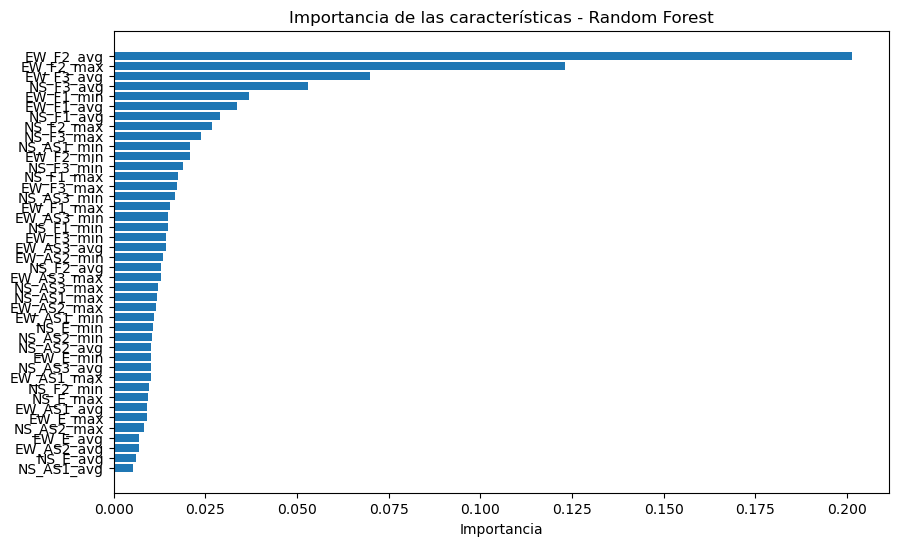

In [6]:

# Definir el modelo Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)

# Aplicar cross-validation con 5 folds
scores_mse = cross_val_score(rf_model, X_train_clipped, y_train, cv=5, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(rf_model, X_train_clipped, y_train, cv=5, scoring='r2')

# Calcular la media de las métricas
mean_mse = -scores_mse.mean()  # Cross-validated MSE
mean_r2 = scores_r2.mean()  # Cross-validated R²

# Imprimir las métricas obtenidas de cross-validation
print(f"Random Forest Regressor con cross-validation (5 folds):")
print(f"MSE promedio (cross-validation): {mean_mse}")
print(f"R² promedio (cross-validation): {mean_r2}")

# Entrenar el modelo con todos los datos de entrenamiento
rf_model.fit(X_train_clipped, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcular las métricas finales en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Imprimir las métricas finales
print(f"Métricas finales en el conjunto de prueba:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")

# Obtener la importancia de las características
importances = rf_model.feature_importances_

# Crear un DataFrame con los nombres de las características y sus importancias
feature_importance_df = pd.DataFrame({
    'Característica': X_train.columns,  # Asegúrate de que 'X_train.columns' contenga los nombres de las columnas
    'Importancia': importances
})

# Ordenar las características por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'])
plt.xlabel("Importancia")
plt.title("Importancia de las características - Random Forest")
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes estén en la parte superior
plt.show()


 95%|=================== | 69/73 [00:27<00:01]       

  0%|          | 0/73 [00:00<?, ?it/s]

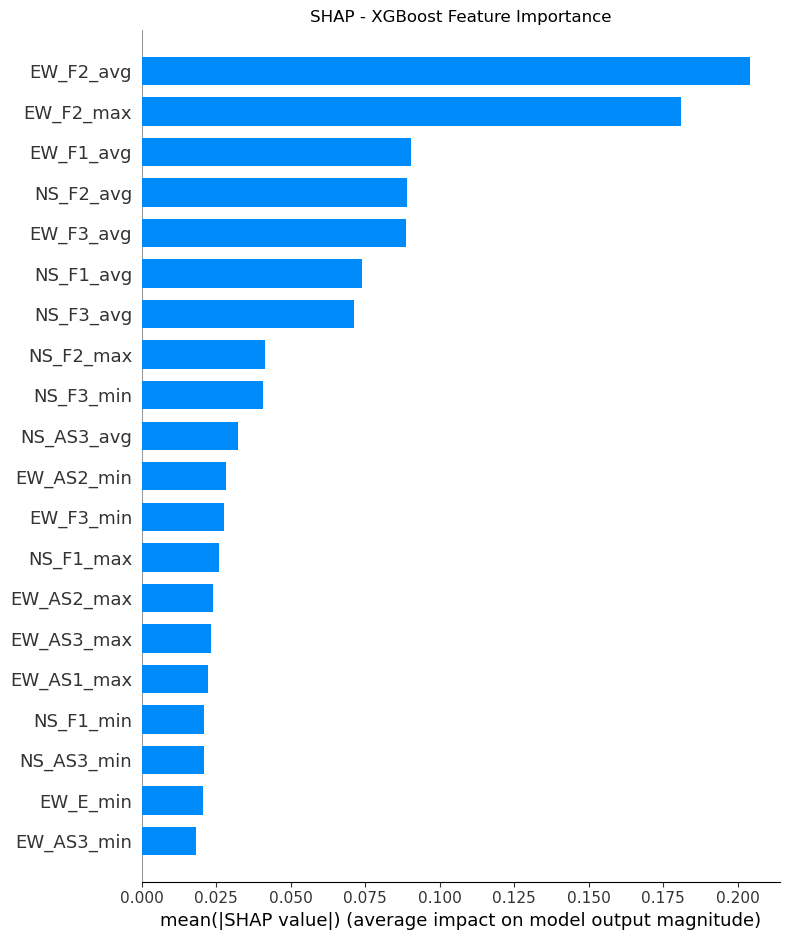

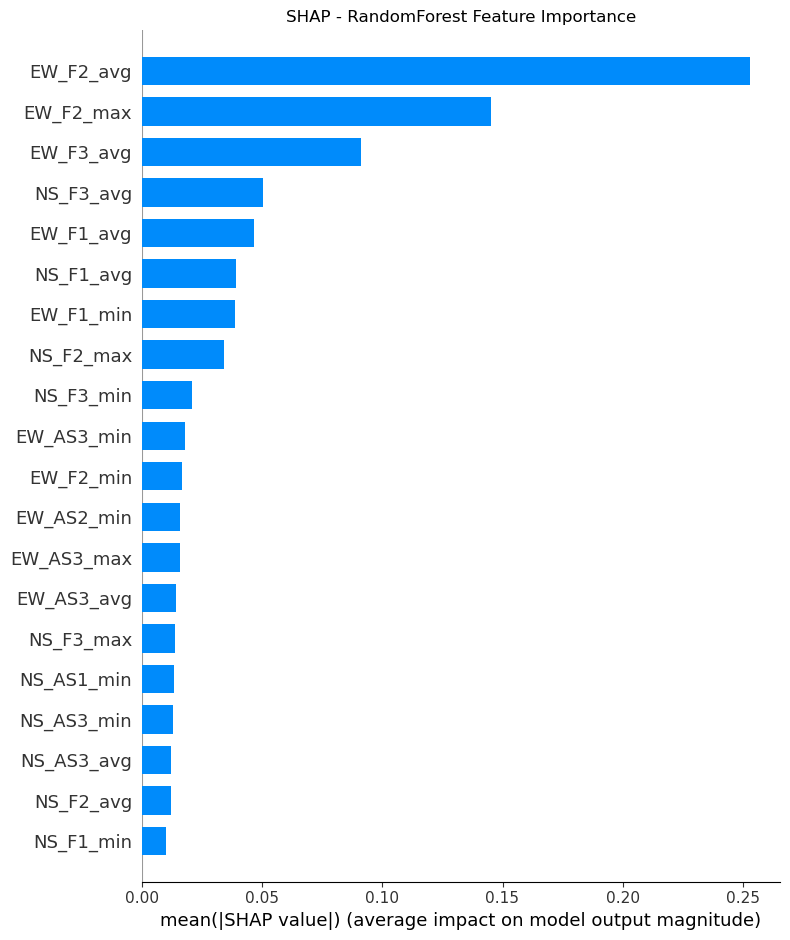

In [8]:


# Reducimos el conjunto de datos de fondo para acelerar SHAP usando shap.sample para todos los modelos
background = shap.sample(X_train, 100)  # Usamos una muestra de 100 datos para los 3 modelos

# Crear un explicador SHAP para cada modelo utilizando la muestra de fondo

# SHAP para XGBoost
explainer_xgb = shap.Explainer(xgboost_model, background)
shap_values_xgb = explainer_xgb(X_test)

# SHAP para RandomForest
explainer_rf = shap.Explainer(rf_model, background)
shap_values_rf = explainer_rf(X_test)

# SHAP para SVR (requiere un KernelExplainer)
explainer_svr = shap.KernelExplainer(svr_model.predict, background)  # SVR no tiene predict_proba
shap_values_svr = explainer_svr.shap_values(X_test)

# Graficar la importancia de las características para XGBoost
plt.title("SHAP - XGBoost Feature Importance")
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

# Graficar la importancia de las características para Random Forest
plt.title("SHAP - RandomForest Feature Importance")
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")



# Opcional: Graficar con puntos (dot plot) en lugar de barras
# Graficar la importancia de las características para XGBoost
# plt.title("SHAP - XGBoost Feature Importance")
# shap.summary_plot(shap_values_xgb, X_test, plot_type="dot")

# Graficar la importancia de las características para Random Forest
# plt.title("SHAP - RandomForest Feature Importance")
# shap.summary_plot(shap_values_rf, X_test, plot_type="dot")




  0%|          | 0/73 [00:00<?, ?it/s]

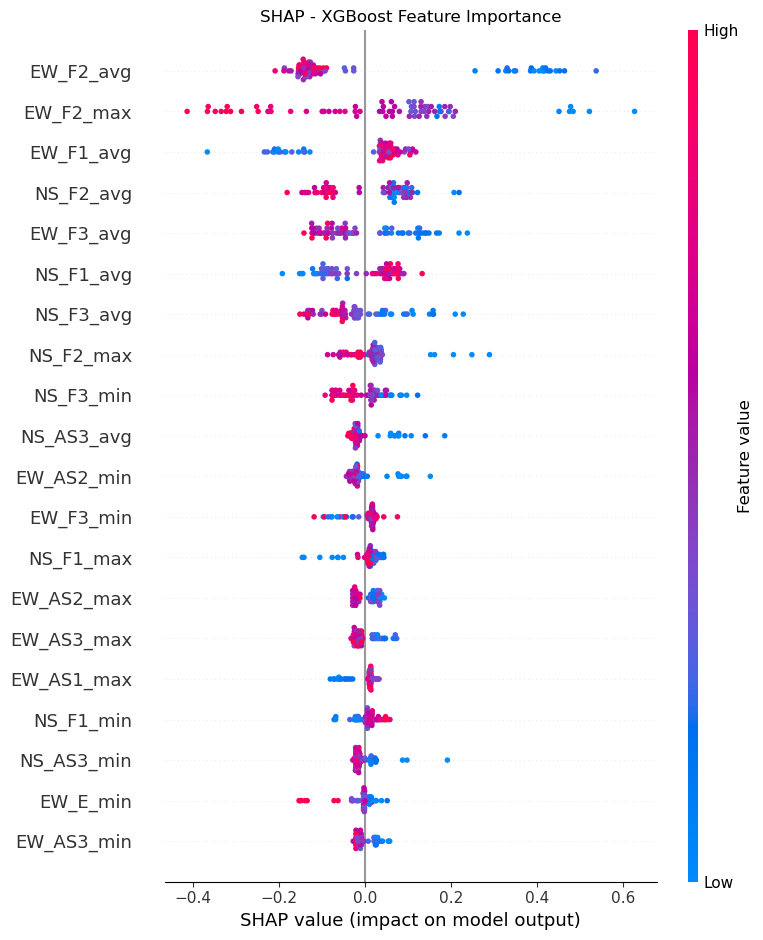

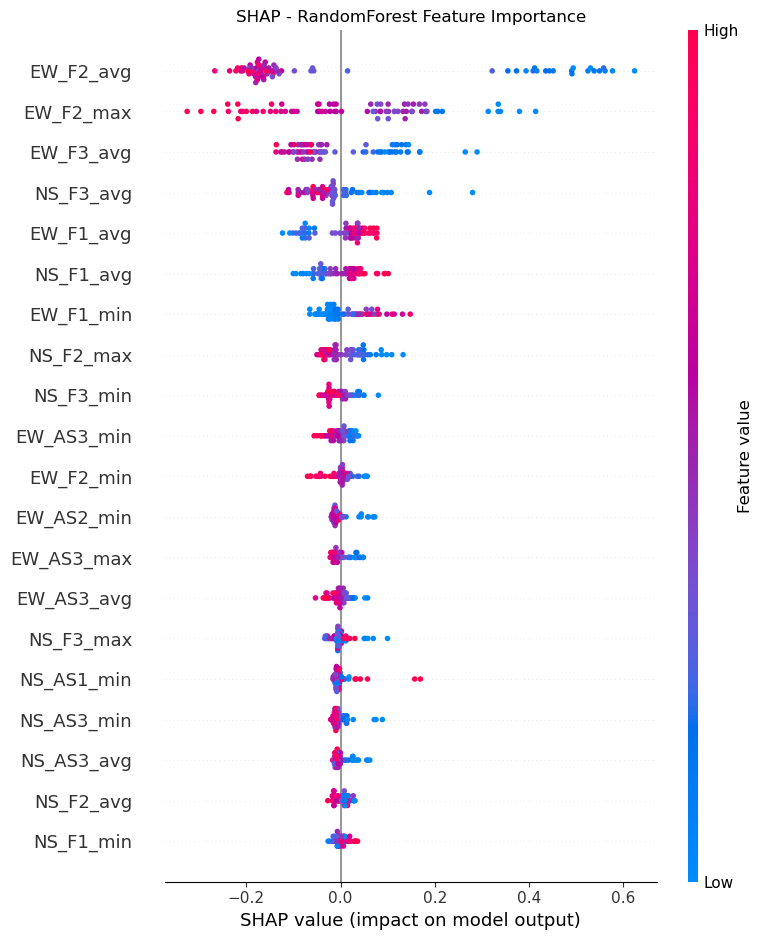

In [9]:
# Reducimos el conjunto de datos de fondo para acelerar SHAP usando shap.sample para todos los modelos
background = shap.sample(X_train, 100)  # Usamos una muestra de 100 datos para los 3 modelos

# Crear un explicador SHAP para cada modelo utilizando la muestra de fondo

# SHAP para XGBoost
explainer_xgb = shap.Explainer(xgboost_model, background)
shap_values_xgb = explainer_xgb(X_test)

# SHAP para RandomForest
explainer_rf = shap.Explainer(rf_model, background)
shap_values_rf = explainer_rf(X_test)

# SHAP para SVR (requiere un KernelExplainer)
explainer_svr = shap.KernelExplainer(svr_model.predict, background)  # SVR no tiene predict_proba
shap_values_svr = explainer_svr.shap_values(X_test)

# Graficar la importancia de las características para XGBoost
#plt.title("SHAP - XGBoost Feature Importance")
#shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

# Graficar la importancia de las características para Random Forest
#plt.title("SHAP - RandomForest Feature Importance")
#shap.summary_plot(shap_values_rf, X_test, plot_type="bar")

# Opcional: Graficar con puntos (dot plot) en lugar de barras
 #Graficar la importancia de las características para XGBoost
plt.title("SHAP - XGBoost Feature Importance")
shap.summary_plot(shap_values_xgb, X_test, plot_type="dot")

# Graficar la importancia de las características para Random Forest
plt.title("SHAP - RandomForest Feature Importance")
shap.summary_plot(shap_values_rf, X_test, plot_type="dot")



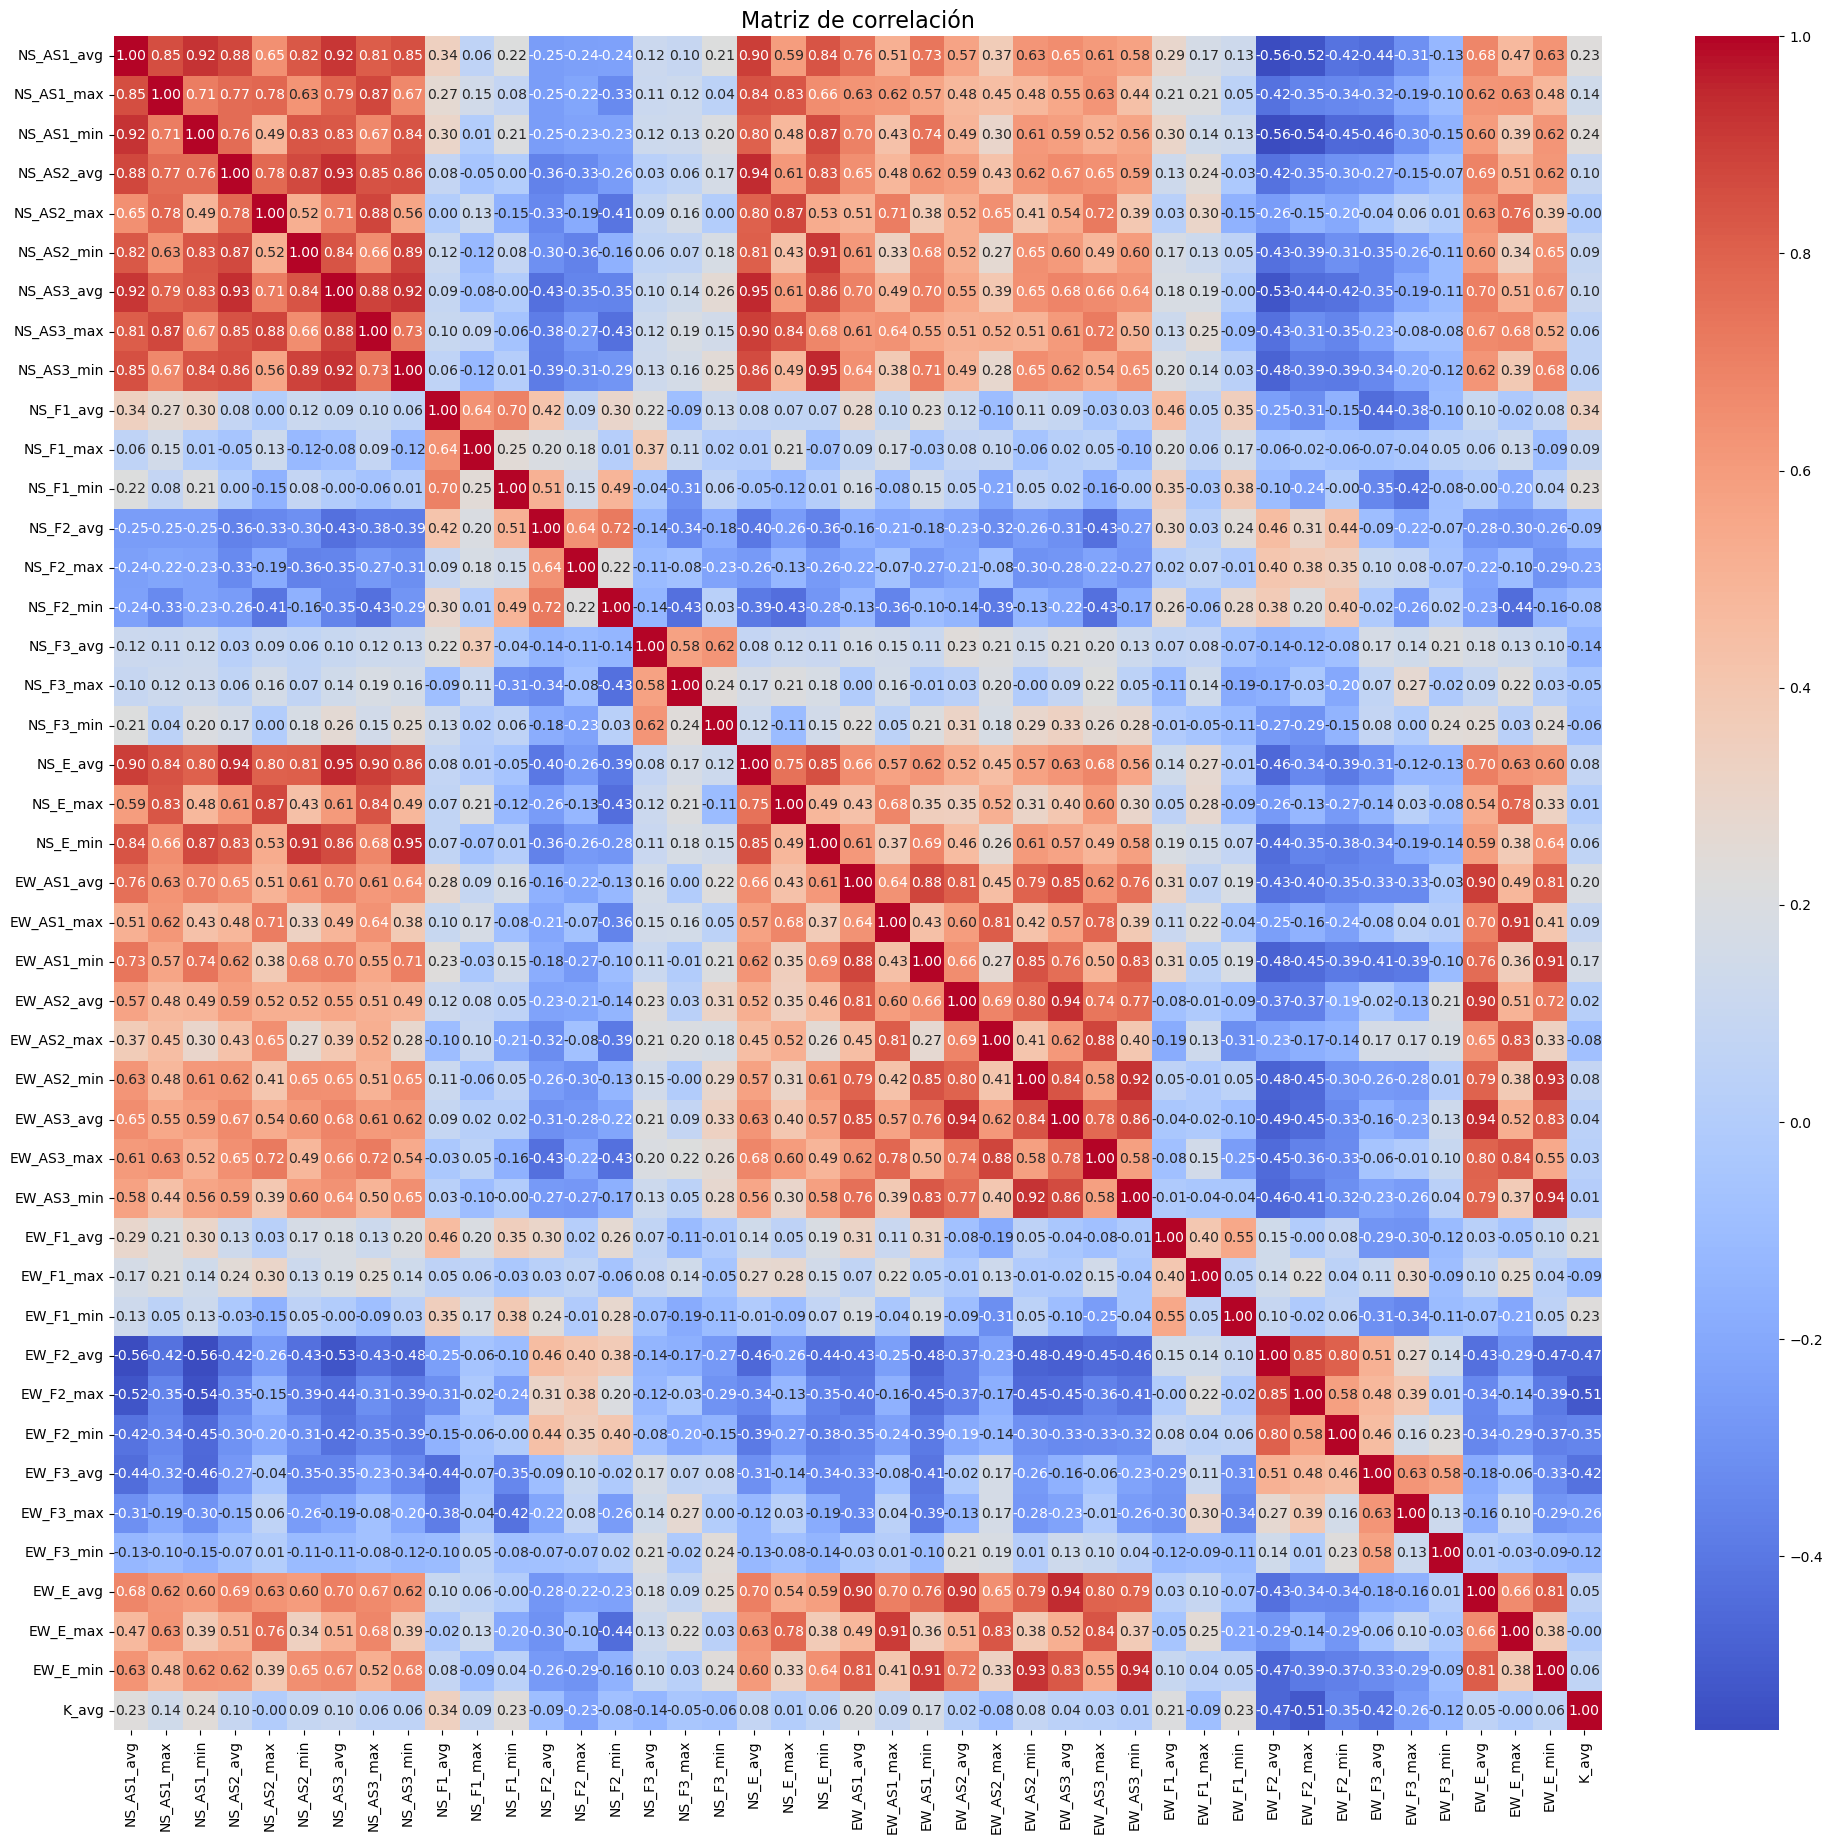

In [7]:

# Crear un dataframe con los datos de entrenamiento (X_train) y la etiqueta (y_train)
df = pd.DataFrame(X_train, columns=nombres[:-1])  # Usamos los nombres de las columnas menos la etiqueta (K_avg)
df["K_avg"] = y_train  # Añadimos la columna de la etiqueta

# Matriz de correlación
corr_matrix = df.corr()

# Graficar la matriz de correlación con un tamaño más grande
plt.figure(figsize=(24, 22))  # Aumenta el tamaño de la figura
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})  # Ajusta el tamaño del texto
plt.title("Matriz de correlación", fontsize=16)

# Guardar la imagen en el notebook
plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')  # Guardar con alta resolución
plt.show()